# I. Loading & Preprocessing the dataset 

Dataset includes 10000 sample, 9000 are train set and the others are test set.

Each sample includes id, category, title, abstract.


In [52]:
!rm -r medlatec
!mkdir medlatec

!for x in 3 4 5 6 7 9 10 11 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 39 55 56 57 58 60 61 62 64 73 74 76; do wget https://raw.githubusercontent.com/minhnq97/medical_data/master/crawl_md_question/c$x.pt.json; done

--2020-09-21 02:42:51--  https://raw.githubusercontent.com/minhnq97/medical_data/master/crawl_md_question/c3.pt.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1544226 (1.5M) [text/plain]
Saving to: ‘c3.pt.json.1’

c3.pt.json.1        100%[===================>]   1.47M  --.-KB/s    in 0.06s   

2020-09-21 02:42:51 (25.2 MB/s) - ‘c3.pt.json.1’ saved [1544226/1544226]

--2020-09-21 02:42:51--  https://raw.githubusercontent.com/minhnq97/medical_data/master/crawl_md_question/c4.pt.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105804

In [53]:
!pip install underthesea

## Loading data

In this notebook, I will attempt to use the title of the data to predict the category of the paper.
 
The data will be recorded with the form of tuples (title, category).

In [54]:
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt
from underthesea import word_tokenize
from underthesea import pos_tag
from tqdm import tqdm
# 39 56 57 has too few samples
# test remove 3 4 
list_index_data = [3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 
                      22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 39, 55, 
                       56, 57, 58, 60, 61, 62, 64, 73, 74, 76]

REPLACE_SHORT_WORD = {"e":"em", "k": "không", "ko": "không", "xn": "xét nghiệm", "bv":"bệnh viện", "bsi": "bác sĩ", "bs": "bác sĩ"}
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@.,;\-\'\\n]')
BAD_SYMBOLS_RE = re.compile('[~!@#$%^&*-+=?:]')


def _format_line(sentence):
    sentence = sentence.lower()
    sentence = REPLACE_BY_SPACE_RE.sub(' ', sentence)
    sentence = BAD_SYMBOLS_RE.sub('', sentence)
    sentence = ' '.join([REPLACE_SHORT_WORD[word] if word in REPLACE_SHORT_WORD else word for word in sentence.split()])
    sentence = ' '.join(["0" if word.isnumeric() else word for word in sentence.split()])
    sentence = ' '.join(["" if any(map(str.isdigit, word)) is True else word for word in sentence.split()])
    # sentence = word_tokenize(sentence, format="text")
    tags = pos_tag(sentence)
    sentence = ' '.join([ w  for w,t in tags if t not in['C', 'Cc', 'CH', 'E', 'I', 'L', 'P', 'R', 'T' ]])

    return sentence

def load_data():
    all_data=[]
    for index in list_index_data:
        with open("c"+ str(index) + ".pt.json", "rt") as f:
          batch_data = json.load(f)
          for data in tqdm(batch_data): 
              # print(data['q_content'])
              # print(data['c_id'])
              all_data.append(( _format_line(data['q_title']) + " " + _format_line(data['q_content']), data['c_id']))
    return all_data

def redefine_data(all_data, threshold=20):
    new_data=[]
    label_list=[]
    label_freq = {}
    for data in all_data:
        c_id = data[1]
        if c_id not in label_freq:
            label_freq[c_id] = 1
        else:
            label_freq[c_id] += 1
    
    for data in all_data:
        c_id = data[1]
        if label_freq[c_id] > threshold:
            new_data.append(data)
            label_list.append(c_id)

    return new_data, list(set(label_list))

def merge_data_by_category(all_data, target_merge=None):
    if target_merge is None:
        return all_data, None
    else:
        new_data=[]
        label_list = []
        for data in all_data:
            c_id = data[1]
            if c_id in target_merge:
                data = (data[0],target_merge[c_id])
            new_data.append(data)
            label_list.append(c_id)
        return new_data, list(set(label_list))

def drop_category(all_data, drop_target=None):
    if drop_target is None:
        return all_data, None
    else:
        new_data=[]
        label_list = []
        for data in all_data:
            c_id = data[1]
            if c_id not in drop_target:
                new_data.append(data)
                label_list.append(c_id)
        return new_data, list(set(label_list))
    


In [55]:
print(_format_line('Chàng trai 9X Quảng Trị khởi nghiệp từ nấm sò'))

chàng trai quảng trị khởi nghiệp nấm sò


In [56]:
all_data = load_data()

100%|██████████| 97/97 [00:01<00:00, 56.78it/s]


In [57]:
len(all_data)

20727

In [58]:
all_data, label_list = merge_data_by_category(all_data, target_merge={'c22':'c22', 'c57':'c22', 'c55':'c22',
                                                                      'c11':'c22','c33':'c22','c10':'c22','c34':'c22', # c22: nội khoa
                                                                      'c5':'c5','c3':'c5','c21':'c21','c19':'c21','c4':'c21'}) #c5: viêm gan; c21: sản phụ khoa
all_data, label_list = drop_category(all_data, drop_target=['c20','c17','c73'])
all_data, label_list = redefine_data(all_data, threshold=50)


In [ ]:
# all_data, label_list = merge_data_by_category(all_data, target_merge={'c35':'c35', 'c34':'c35', 'c21':'c35', 'c31':'c35' , 
#                                                                       'c55':'c35','c25':'c35','c10':'c22','c34':'c22',
#                                                                       'c5':'c5','c3':'c5','c21':'c21','c19':'c21','c4':'c21'})
# all_data, label_list = drop_category(all_data, drop_target=['c20','c17','c73'])
# all_data, label_list = redefine_data(all_data, threshold=50)


In [59]:
len(all_data)

19773

In [60]:
all_data[-1]

('tư vấn tiêm vacxin dại chào bác sĩ em tiêm vacxin verorab liều đầu tiên mũi lý do em bị mèo cào chân vet thương dài có chảy máu liều tiếp theo ngày sau rơi chủ nhật em có công việc gấp phải về quê em dời ngày tiêm hôm sau là thứ duoc có ảnh hưởng quá trình điều trị tác dụng kháng sinh có mất hieu',
 'c76')

In [61]:
len(label_list)

21

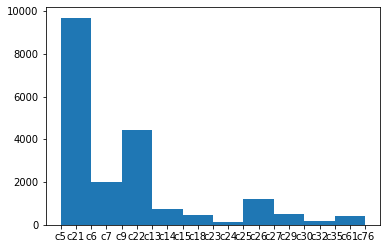

In [62]:
list_category = [x[1] for x in all_data]
plt.hist(list_category)
plt.show()

In [63]:
print(all_data[0])
print(all_data[-1])

('viêm gan b chào bác sĩ em làm xét nghiệm hbsag là coi hbsab định lượng u l kết quả dương tính biết em có phải thực hiện điều trị uống thuốc em cảm ơn', 'c5')
('tư vấn tiêm vacxin dại chào bác sĩ em tiêm vacxin verorab liều đầu tiên mũi lý do em bị mèo cào chân vet thương dài có chảy máu liều tiếp theo ngày sau rơi chủ nhật em có công việc gấp phải về quê em dời ngày tiêm hôm sau là thứ duoc có ảnh hưởng quá trình điều trị tác dụng kháng sinh có mất hieu', 'c76')


## Train/dev split

The train set has a very good distribution between each class. I get the ratio between train and dev set of 90 - 10.

In [65]:
from sklearn.model_selection import train_test_split

texts, labels = zip(*all_data)
label_list = list(set(labels))
train_texts, valid_texts, train_labels, valid_labels = train_test_split(texts, labels, test_size=0.2, random_state=0,stratify=labels)

In [66]:
train_texts[0]

'tư vấn kết quả xét nghiệm pcr lậu chlamydia chào bác sĩ em là nam tuổi đầu tháng em có quan hệ tình dục an toàn đầu tháng em có làm xét nghiệm pcr lậu chlamydia bệnh viện medlatec kết quả sau âm tính chlamydia trachomatis âm tính nesseria gonorrhoeae bác sĩ tư vấn em kết quả em xin cảm ơn'

## Preparing dataset

After received preprocessed data, I build a vocabulary by Tokenizer from Keras.
Followed by convert sentence to tensor format and pad sequences with the same length.

In [67]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

RANDOM_SEED=0
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

vocab_size = 15000

tokenizer = Tokenizer(num_words=vocab_size,filters='')
tokenizer.fit_on_texts(train_texts)

In [68]:
vocab = tokenizer.word_index
len(vocab)

11208

In [69]:
MIN_LENGTH = len(min(train_texts, key=len))
print(MIN_LENGTH)
MAX_LENGTH = len(max(train_texts, key=len))
print(MAX_LENGTH)

11
3641


### Converting data to tensors

Convert the sample sequences into tensors.

In [70]:
X_train = tokenizer.texts_to_sequences(train_texts)
X_valid = tokenizer.texts_to_sequences(valid_texts)

### Padding the sequence

In [71]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def one_hot_label(vector, index):
    vector[index] = 1
    return vector

MAXLEN=512
label_index = dict(enumerate(label_list))
label_index = dict([(value, key) for key, value in label_index.items()]) 

X_train_pad = pad_sequences(X_train, maxlen=MAXLEN, padding='pre')
X_valid_pad = pad_sequences(X_valid, maxlen=MAXLEN, padding='pre')
y_train = np.array([one_hot_label(np.zeros((len(label_index))), label_index[lb]) for lb in train_labels])
y_valid = np.array([one_hot_label(np.zeros((len(label_index))), label_index[lb]) for lb in valid_labels])

## Label analysis

In [72]:
def get_documents_by_label(texts, labels, chosen_label):
    chosen_texts=[]
    for text, label in zip(texts, labels):
        if label == chosen_label:
            chosen_texts.append(text)
    return chosen_texts

def analyse_words_in_texts(texts, tags):
    word_dict={}
    for text in texts:
        tagged_sent = pos_tag(text)
        for tuple_word in tagged_sent:
            if tuple_word[1] in tags :
                if tuple_word[0] not in word_dict:
                    word_dict[tuple_word[0]] = 1
                else:
                    word_dict[tuple_word[0]] += 1
    return sorted(word_dict.items(), key=lambda item: item[1], reverse=True)

texts = get_documents_by_label(train_texts, train_labels, 'c29')
word_dict = analyse_words_in_texts(texts, ['N', 'Np'])
word_dict[:20]

[('máu', 39),
 ('kết quả', 34),
 ('l', 24),
 ('sau', 20),
 ('chỉ số', 18),
 ('ngày', 15),
 ('sỹ', 15),
 ('chi tiết', 15),
 ('cholesterol', 15),
 ('mmol', 14),
 ('architect', 11),
 ('bé', 10),
 ('cobas', 10),
 ('bạch cầu', 9),
 ('thể tích', 6),
 ('âm tính', 6),
 ('muối', 6),
 ('bệnh', 5),
 ('thuốc', 5),
 ('ldl', 5)]

# II. Building Model

Our network contains:

- A LSTM model
- A Transformer model



In [73]:
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Conv1D, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.utils import class_weight
import numpy as np

EMB_DIM = 300
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced',
                                                 np.unique(train_labels),
                                                 train_labels)))

In [74]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def model_report(model, X_test_pad, y_test):
    y_pred = np.argmax(model.predict(X_test_pad),axis=1)
    y_test = np.argmax(y_test,axis=1)

    confusion = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(12,12))
    ax= plt.subplot()
    sns.heatmap(confusion, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(label_list); ax.yaxis.set_ticklabels(label_list);
    print(classification_report(y_test, y_pred,target_names=label_list))
    pass

def plotting_acc_loss(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    pass

## Tf-Idf Analysis

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_texts)
X_valid = vectorizer.transform(valid_texts)

y_train = np.array([one_hot_label(np.zeros((len(label_index))), label_index[lb]) for lb in train_labels])
y_valid = np.array([one_hot_label(np.zeros((len(label_index))), label_index[lb]) for lb in valid_labels])

In [76]:
X_valid[0]

<1x175152 sparse matrix of type '<class 'numpy.float64'>'
	with 108 stored elements in Compressed Sparse Row format>

In [77]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.model_selection import cross_val_score
import pandas as pd

clf = LogisticRegression(solver='lbfgs', multi_class='ovr')
clf.fit(X_train, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [78]:
from sklearn import metrics

valid_preds = clf.predict(X_valid)
accuracy = metrics.accuracy_score(valid_labels, valid_preds)
print("# Test accuracy: {}".format(accuracy))

# Test accuracy: 0.7173198482932996


In [79]:
model = LinearSVC()
model.fit(X_train, train_labels)

valid_preds = model.predict(X_valid)
accuracy = metrics.accuracy_score(valid_labels, valid_preds)
print("# Test accuracy: {}".format(accuracy))

# Test accuracy: 0.7426042983565108


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         c76       0.76      0.53      0.62        47
          c5       0.72      0.67      0.69       105
          c6       0.85      0.96      0.90        70
         c25       0.56      0.40      0.47        25
         c13       0.84      0.93      0.88      1664
         c29       0.61      0.65      0.63       612
         c23       0.67      0.43      0.52        14
          c9       0.67      0.17      0.27        12
         c30       0.62      0.73      0.67        74
         c27       0.73      0.59      0.65       165
         c35       0.61      0.54      0.58        94
         c15       0.00      0.00      0.00        10
         c18       0.00      0.00      0.00        16
         c32       0.57      0.18      0.28        22
         c21       0.71      0.73      0.72        44
          c7       0.65      0.53      0.58       274
         c24       0.57      0.36      0.44       129
         c14       0.00    

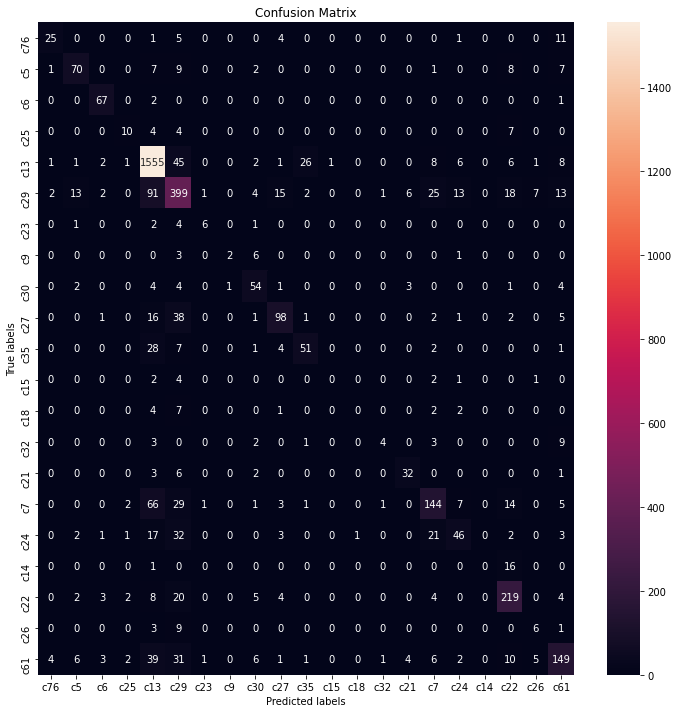

In [80]:
confusion = confusion_matrix(valid_labels, valid_preds)

plt.figure(figsize=(12,12))
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(label_list); ax.yaxis.set_ticklabels(label_list);
print(classification_report(valid_labels, valid_preds,target_names=label_list))

In [81]:
m

NameError: ignored

## LSTM Model

In [ ]:
lstm_model = tf.keras.Sequential()
lstm_model.add(InputLayer(input_shape=(MAXLEN, )))
lstm_model.add(Embedding(vocab_size, EMB_DIM))
lstm_model.add(Conv1D(filters=EMB_DIM,
               kernel_size=8,
               strides=1, padding='same',
               activation='relu'))
lstm_model.add(LSTM(512))
# lstm_model.add(Flatten())
lstm_model.add(Dense(len(label_list), activation='softmax'))

lstm_model.compile(optimizer=Adam(lr=1e-3),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = lstm_model.fit(X_train_pad, y_train,
          epochs=5,
          batch_size=32,
          validation_data=(X_valid_pad, y_valid),
         )

In [ ]:
lstm_model = tf.keras.Sequential()
lstm_model.add(InputLayer(input_shape=(MAXLEN, )))
lstm_model.add(Embedding(vocab_size, EMB_DIM))
lstm_model.add(LSTM(512))
lstm_model.add(Dense(len(label_list), activation='softmax'))

lstm_model.compile(optimizer=Adam(lr=1e-3),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = lstm_model.fit(X_train_pad, y_train,
          epochs=5,
          batch_size=32,
          validation_data=(X_valid_pad, y_valid),
         )

In [ ]:
plotting_acc_loss(history)

## Transformer Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output
    

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, pretrained_emb_layer):
        super(TokenAndPositionEmbedding, self).__init__()
        if pretrained_emb_layer is None:
          self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        else:
          self.token_emb = pretrained_emb_layer
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [ ]:
num_heads = 8  # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer
EMB_DIM=256
inputs = layers.Input(shape=(MAXLEN,))
embedding_layer = TokenAndPositionEmbedding(MAXLEN, vocab_size, EMB_DIM, None)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(EMB_DIM, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(len(label_list), activation="softmax")(x)

transformer_model = keras.Model(inputs=inputs, outputs=outputs)

transformer_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = transformer_model.fit(X_train_pad, y_train,
          epochs=3,
          batch_size=32,
          validation_data=(X_valid_pad, y_valid)
         )


In [ ]:
plotting_acc_loss(history)

# III. (Additional) Using pretrained embedding

In [ ]:
# Uncomment this to run Additional section
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.vi.300.vec.gz
!gunzip cc.vi.300.vec.gz

In [82]:
import os

PRETRAINED_EMBEDDING_DIM=300
embeddings_index = {}
with open('cc.vi.300.vec', "rt") as f:
    f.readline()
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 2000000 word vectors.


In [83]:
num_oov=0
num_iov=0
embedding_matrix = np.zeros((len(vocab.keys()) + 1, PRETRAINED_EMBEDDING_DIM))
for word, i in vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        num_iov+=1
    else:
        num_oov+=1
print("Total oov from pretrained:", num_oov, num_iov)

Total oov from pretrained: 3032 8176


In [84]:
from collections import defaultdict

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = 300
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

    
# and a tf-idf version of the same
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = 300
        # if len(word2vec)>0:
        #     self.dim=len(word2vec[next(iter(glove_small))])
        # else:
        #     self.dim=0
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier

svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x, sublinear_tf=True, max_df=0.5, ngram_range=(1,2))),
                      ("svm", LinearSVC())])

In [86]:
list_train_text = [np.array(text.split()) for text in train_texts]
list_valid_text = [np.array(text.split()) for text in valid_texts]


In [87]:
svc_tfidf.fit(list_train_text, train_labels)

valid_preds = svc_tfidf.predict(list_valid_text)
accuracy = metrics.accuracy_score(valid_labels, valid_preds)
print("# Test accuracy: {}".format(accuracy))

# Test accuracy: 0.722629582806574


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         c76       0.75      0.57      0.65        47
          c5       0.67      0.69      0.68       105
          c6       0.81      0.94      0.87        70
         c25       0.39      0.28      0.33        25
         c13       0.84      0.93      0.88      1664
         c29       0.58      0.63      0.60       612
         c23       0.67      0.43      0.52        14
          c9       0.33      0.17      0.22        12
         c30       0.60      0.66      0.63        74
         c27       0.69      0.56      0.62       165
         c35       0.65      0.53      0.58        94
         c15       0.50      0.10      0.17        10
         c18       0.00      0.00      0.00        16
         c32       0.50      0.23      0.31        22
         c21       0.66      0.61      0.64        44
          c7       0.61      0.49      0.54       274
         c24       0.52      0.35      0.42       129
         c14       0.00    

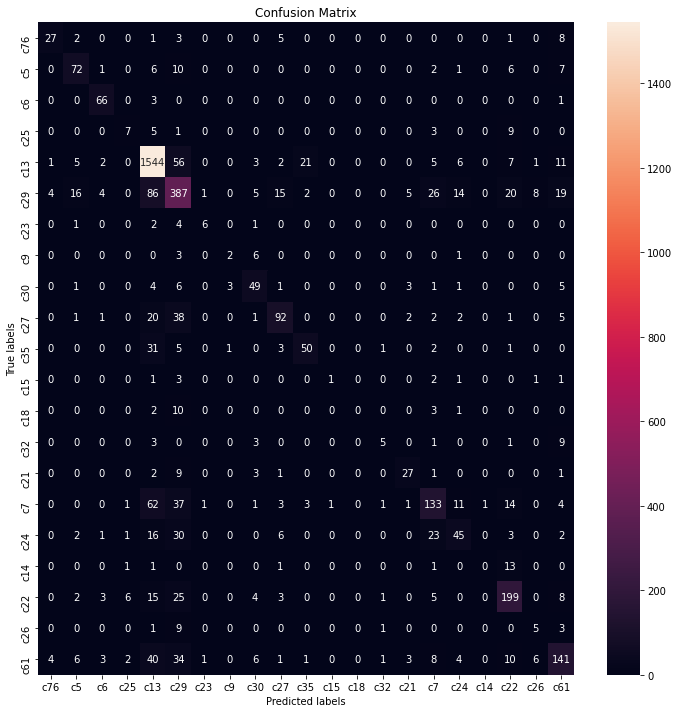

In [90]:
confusion = confusion_matrix(valid_labels, valid_preds)

plt.figure(figsize=(12,12))
ax= plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(label_list); ax.yaxis.set_ticklabels(label_list);
print(classification_report(valid_labels, valid_preds,target_names=label_list))

In [ ]:
c18_texts = get_documents_by_label(valid_texts, valid_labels, 'c18')
c18_texts[:20]

In [ ]:
def inferrence_sentence(model, sent):
    x = tokenizer.texts_to_sequences([sent])
    x_pad = pad_sequences(x, maxlen=MAXLEN, padding='pre')
    y_pred = np.argmax(model.predict(x_pad),axis=1)
    print(label_list[y_pred[0]])

# V. References

1. [LSTM Baseline model](https://colab.research.google.com/drive/1ywAxRuIPQrEqOkEwtzfGWhJjAR95AdfI?usp=sharing)

2. [Transformer by Tensorflow keras](https://keras.io/examples/nlp/text_classification_with_transformer/)